# ***Credit Card Fraud Detection***

This work was coded and written by *Garance SUSINI, Leonardo LEONE et Océane ROUX*, three *ESPCI Paris* students.

In this work, based on the dataset in 'https://www.kaggle.com/mlg-ulb/creditcardfraud', we explored credit card fraud detection using Deep Learning techniques in Python.

April 2022

# Librairies and data importation

In [4]:
# Importing some useful libraries/ 

import torch as th
import torch.nn as nn
print('Pytorch version : ',th.__version__) 
import numpy as np
import pandas as pd
print('Pandas version : ',pd.__version__)
import math
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix


# Importing to create the model

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split


#Data augmentation Librairies

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

Pytorch version :  1.13.1+cu117
Pandas version :  1.5.2


2022-12-21 11:40:56.151805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 11:40:56.274906: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-21 11:40:56.918415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-21 11:40:56.918466: W tensorflow/compiler/xla/stream_executor/platform

In [2]:

import numpy as np

In [6]:
# Reading the csv file in the drive

import zipfile
try:
  zf = zipfile.ZipFile('Fraud_detection_db.zip') #Put the path of the document Fraud_detection_db.zip 
except:
  print('Incorrect path')

# now read the csv file - there is only one .csv in the .zip
df = pd.read_csv(zf.open('creditcard.csv'))

# Data preprocessing

In [ ]:
# modifying the database / variables


df1=df.drop(df[df['Class']==0].index, axis=0) #Non Fraudulent
df0=df.drop(df[df['Class']==1].index, axis=0) #Fraudulent
df1=df1.drop(['Time', 'Amount','V2', 'V3', 'V5', 'V7', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1) #We chose the most important inputs
df0=df0.drop(['Time', 'Amount','V2', 'V3', 'V5', 'V7', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1) #We chose the most important inputs

df1_sample=df1.sample(n = 100, random_state=0)
df0_sample=df0.sample(n = 100, random_state=0)

df1=df1.drop(df1_sample.index, axis=0)
df0=df0.drop(df0_sample.index, axis=0)

Test=pd.concat([df1_sample, df0_sample])
Train=pd.concat([df1, df0])


# Separating train and test/validation set

X_train=Train.drop(['Class'], axis=1)
y_train=Train['Class']
y_train=y_train.reset_index()
y_train=y_train.drop(['index'], axis=1)


X_test=Test.drop(['Class'], axis=1)
y_test=Test['Class']
y_test=y_test.reset_index()
y_test=y_test.drop(['index'], axis=1)

#Normalization of the dataset

transformer=MinMaxScaler()
columns=X_train.columns.tolist()
X_train=transformer.fit_transform(X_train)
X_train=pd.DataFrame(X_train, columns = columns)
X_test=transformer.transform(X_test)
X_test=pd.DataFrame(X_test, columns = columns)

# Data augmentation

## Undersampling

In [ ]:


df_train_under=X_train.copy()
df_test_under=X_test.copy()

df_train_under['Class']=y_train
df_test_under['Class']=y_test

df_train_under1=df_train_under.drop(df_train_under[df_train_under['Class']==0].index, axis=0) #Fraudulent
df_train_under1=df_train_under1.sample(frac=1, random_state=0) #To shuffle the data

df_train_under0=df_train_under.drop(df_train_under[df_train_under['Class']==1].index, axis=0) #Non fraudulent
df_train_under0=df_train_under0.sample(frac=1, random_state=0) #To shuffle the data
df_train_under0=df_train_under0.sample(6*len(df_train_under1), random_state=0) #Now we have 6 times more non fraudulent data than fraudulent data

df_train_under=pd.concat([df_train_under0, df_train_under1], ignore_index=True)
df_train_under=df_train_under.sample(frac=1, random_state=0)

## ADASYN

proportion of class 0 and 1 before data augmentation


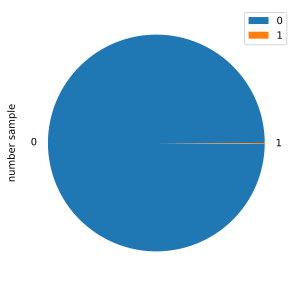

proportion of class 0 and 1 after data augmentation


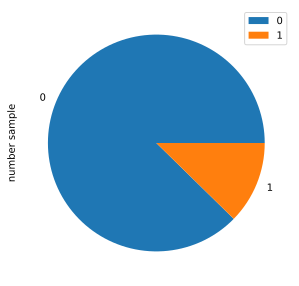

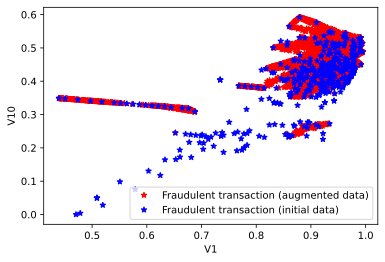

In [ ]:


ada = ADASYN()
x_synth , Y_synth = ada.fit_resample(X_train, y_train) #Data augmentation

X_synth0=x_synth.drop(Y_synth[Y_synth['Class']==1].index, axis=0) #Non fraudulent
X_synth0=X_synth0.sample(frac=1, random_state=0) #cTo shuffle the data
X_synth1=x_synth.drop(Y_synth[Y_synth['Class']==0].index, axis=0) #Fraudulent
X_synth1=X_synth1.sample(frac=1, random_state=0) #To shuffle the data
X_synth1=X_synth1[0:40000] #We don't keep only 40 000 created data. We want to have 6 times more non fraudulent data than fraudulent data

X0=X_train.drop(y_train[y_train['Class']==1].index, axis=0) #Non fraudulent
X0=X0.sample(frac=1, random_state=0) #To shuffle the data
X1=X_train.drop(y_train[y_train['Class']==0].index, axis=0) #Fraudulent

print('proportion of class 0 and 1 before data augmentation')
non_augmented = pd.DataFrame({'number sample': [len(X0), len(X1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = non_augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

print('proportion of class 0 and 1 after data augmentation')
augmented = pd.DataFrame({'number sample': [len(X_synth0), len(X_synth1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

plt.plot(X_synth1['V1'][:10000], X_synth1['V10'][:10000], '*', color='red', label='Fraudulent transaction (augmented data)')
plt.plot(X1['V1'], X1['V10'], '*', color='blue', label='Fraudulent transaction (initial data)')
plt.xlabel('V1')
plt.ylabel('V10')
plt.legend()
plt.show()


Zero=[0]*len(X_synth0)
X_synth0['Class']=Zero

One=[1]*len(X_synth1)
X_synth1['Class']=One

Data_augmented=pd.concat([X_synth0, X_synth1], ignore_index=True)
Data_augmented=Data_augmented.sample(frac=1, random_state=0)

df_train_ada=Data_augmented

X_test['Class']=y_test['Class']
Data_augmented_test=X_test.sample(frac=1, random_state=0)

df_test_ada=Data_augmented_test

## SMOTE

proportion of class 0 and 1 before data augmentation


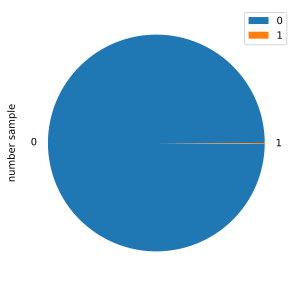

proportion of class 0 and 1 after data augmentation


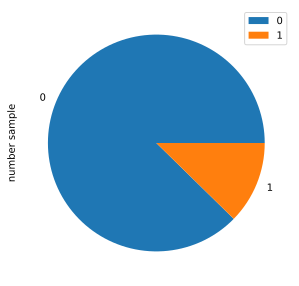

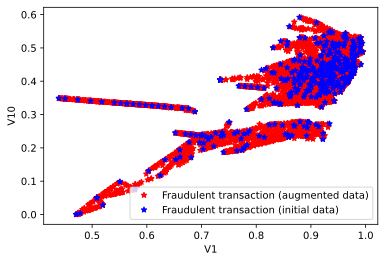

In [ ]:
smote = SMOTE()
x_synth , Y_synth = smote.fit_resample(X_train, y_train) #Data augmentation

X_synth0=x_synth.drop(Y_synth[Y_synth['Class']==1].index, axis=0) #Non fraudulent
X_synth0=X_synth0.sample(frac=1, random_state=0) #To shuffle the data
X_synth1=x_synth.drop(Y_synth[Y_synth['Class']==0].index, axis=0) #Fraudulent
X_synth1=X_synth1.sample(frac=1, random_state=0) #To shuffle the data
X_synth1=X_synth1[0:40000] #We want to have 6 times more non fraudulent data than fraudulent data

X0=X_train.drop(y_train[y_train['Class']==1].index, axis=0) #Non fraudulent
X0=X0.sample(frac=1, random_state=0) #To shuffle the data
X1=X_train.drop(y_train[y_train['Class']==0].index, axis=0) #Fraudulent

print('proportion of class 0 and 1 before data augmentation')
non_augmented = pd.DataFrame({'number sample': [len(X0), len(X1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = non_augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

print('proportion of class 0 and 1 after data augmentation')
augmented = pd.DataFrame({'number sample': [len(X_synth0), len(X_synth1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

plt.plot(X_synth1['V1'][:10000], X_synth1['V10'][:10000], '*', color='red', label='Fraudulent transaction (augmented data)')
plt.plot(X1['V1'], X1['V10'], '*', color='blue', label='Fraudulent transaction (initial data)')
plt.xlabel('V1')
plt.ylabel('V10')
plt.legend()
plt.show()


Zero=[0]*len(X_synth0)
X_synth0['Class']=Zero

One=[1]*len(X_synth1)
X_synth1['Class']=One

Data_augmented=pd.concat([X_synth0, X_synth1], ignore_index=True)
Data_augmented=Data_augmented.sample(frac=1, random_state=0)

df_train_smote=Data_augmented

X_test['Class']=y_test['Class']
Data_augmented_test=X_test.sample(frac=1, random_state=0)

df_test_smote=Data_augmented_test

## ADASYN + Undersampling

proportion of class 0 and 1 before data augmentation


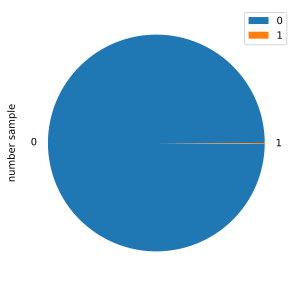

proportion of class 0 and 1 after data augmentation


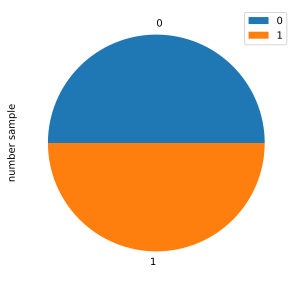

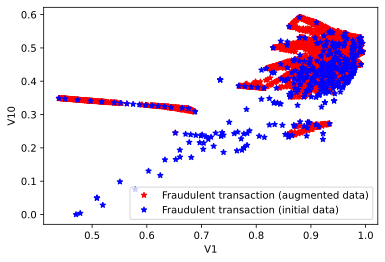

In [ ]:
ada = ADASYN()
x_synth , Y_synth = ada.fit_resample(X_train, y_train) #Data augmentation

X_synth0=x_synth.drop(Y_synth[Y_synth['Class']==1].index, axis=0) #Non fraudulent
X_synth0=X_synth0.sample(frac=1, random_state=0) #To shuffle the data
X_synth0=X_synth0[0:40000] #We want to have the same number of fraudulent and non fraudulent data
X_synth1=x_synth.drop(Y_synth[Y_synth['Class']==0].index, axis=0) #Fraudulent
X_synth1=X_synth1.sample(frac=1, random_state=0) #To shuffle the data
X_synth1=X_synth1[0:40000] #We want to have the same number of fraudulent and non fraudulent data

X0=X_train.drop(y_train[y_train['Class']==1].index, axis=0) #Non fraudulent
X0=X0.sample(frac=1, random_state=0) #To shuffle the data
X1=X_train.drop(y_train[y_train['Class']==0].index, axis=0) #Fraudulent

print('proportion of class 0 and 1 before data augmentation')
non_augmented = pd.DataFrame({'number sample': [len(X0), len(X1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = non_augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

print('proportion of class 0 and 1 after data augmentation')
augmented = pd.DataFrame({'number sample': [len(X_synth0), len(X_synth1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()


plt.plot(X_synth1['V1'][:10000], X_synth1['V10'][:10000], '*', color='red', label='Fraudulent transaction (augmented data)')
plt.plot(X1['V1'], X1['V10'], '*', color='blue', label='Fraudulent transaction (initial data)')
plt.xlabel('V1')
plt.ylabel('V10')
plt.legend()
plt.show()


Zero=[0]*len(X_synth0)
X_synth0['Class']=Zero

One=[1]*len(X_synth1)
X_synth1['Class']=One

Data_augmented=pd.concat([X_synth0, X_synth1], ignore_index=True)
Data_augmented=Data_augmented.sample(frac=1, random_state=0)

df_train_ada_en=Data_augmented

X_test['Class']=y_test['Class']
Data_augmented_test=X_test.sample(frac=1, random_state=0)

df_test_ada_en=Data_augmented_test

## SMOTE + Undersampling

proportion of class 0 and 1 before data augmentation


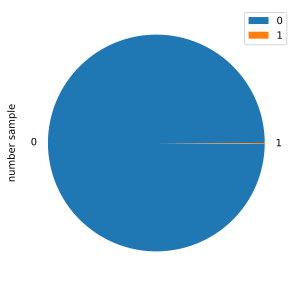

proportion of class 0 and 1 after data augmentation


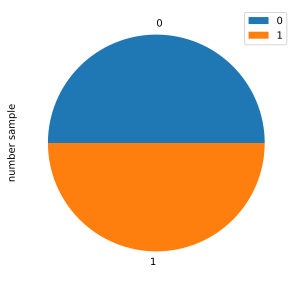

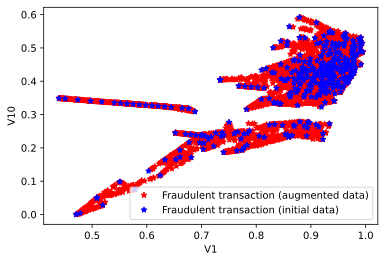

In [ ]:

smote = SMOTE()
x_synth , Y_synth = smote.fit_resample(X_train, y_train) #Data Augmentation

X_synth0=x_synth.drop(Y_synth[Y_synth['Class']==1].index, axis=0) #Non fraudulent
X_synth0=X_synth0.sample(frac=1, random_state=0) #To shuffle the data
X_synth0=X_synth0[0:40000]#We want to have the same number of fraudulent and non fraudulent data
X_synth1=x_synth.drop(Y_synth[Y_synth['Class']==0].index, axis=0) #Fraudulent
X_synth1=X_synth1.sample(frac=1, random_state=0) #To suffle the data
X_synth1=X_synth1[0:40000] #We want to have the same number of fraudulent and non fraudulent data

X0=X_train.drop(y_train[y_train['Class']==1].index, axis=0) #Non fraudulent
X0=X0.sample(frac=1, random_state=0) #To shuffle the data
X1=X_train.drop(y_train[y_train['Class']==0].index, axis=0) #Fraudulent

print('proportion of class 0 and 1 before data augmentation')
non_augmented = pd.DataFrame({'number sample': [len(X0), len(X1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = non_augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

print('proportion of class 0 and 1 after data augmentation')
augmented = pd.DataFrame({'number sample': [len(X_synth0), len(X_synth1)],
                   'class': ['Non Fraudulent', 'Fraudulent']})
plot = augmented.plot.pie(y='number sample', figsize=(5, 5))
plt.show()

plt.plot(X_synth1['V1'][:10000], X_synth1['V10'][:10000], '*', color='red', label='Fraudulent transaction (augmented data)')
plt.plot(X1['V1'], X1['V10'], '*', color='blue', label='Fraudulent transaction (initial data)')
plt.xlabel('V1')
plt.ylabel('V10')
plt.legend()
plt.show()


Zero=[0]*len(X_synth0)
X_synth0['Class']=Zero

One=[1]*len(X_synth1)
X_synth1['Class']=One

Data_augmented=pd.concat([X_synth0, X_synth1], ignore_index=True)
Data_augmented=Data_augmented.sample(frac=1, random_state=0)

df_train_smote_en=Data_augmented

X_test['Class']=y_test['Class']
Data_augmented_test=X_test.sample(frac=1, random_state=0)

df_test_smote_en=Data_augmented_test

# Neuron network

In [ ]:
#This function enables to convert panda data frame into pytorch tensor.
def conversion(df_train, df_test, conv) :
  X_train=df_train.drop(['Class'],axis=1)
  y_train=df_train['Class']

  X_test=df_test.drop(['Class'],axis=1)
  y_test=df_test['Class']

  # Convertion of Pandas dataframe into Tensor
  y_train=y_train.tolist()
  y_train=th.FloatTensor(y_train)
  y_train = y_train.type(th.LongTensor)  #PyTorch won't accept a FloatTensor as categorical target

  y_test=y_test.tolist()
  y_test=th.FloatTensor(y_test)
  y_test = y_test.type(th.LongTensor) #PyTorch won't accept a FloatTensor as categorical target

  X_train=X_train.values.tolist()
  X_train=th.FloatTensor(X_train)
  if conv==1: #If there is a convolution 1D in the neuron network we need to unskeeze the data
    X_train = th.unsqueeze(X_train, dim=-1)

  X_test=X_test.values.tolist()
  X_test=th.FloatTensor(X_test)
  if conv==1: #If there is a convolution 1D in the neuron network we need to unskeeze the data
    X_test = th.unsqueeze(X_test, dim=-1)

  return(X_train, y_train, X_test, y_test)


In [ ]:
#This function enables to train the model
def train(model, df_train, df_test, conv, epochs=15):
    X_train, y_train, X_test, y_test = conversion(df_train, df_test, conv)
    BestAccuracy=0
    loss_fn=nn.NLLLoss()

    ### Mini-batching and shuffle 
    Ntrain = X_train.shape[0]
    Ntest = X_test.shape[0]
    idx = np.arange(Ntrain) #It creates a vector between 0 and Ntrain
    batch_size = 200
    nbatch = int(Ntrain/batch_size)




    train_losses,test_losses, test_accuracies=[],[],[]


    for e in range(epochs):
        model.train()
        np.random.shuffle(idx) # shuffle idx
        running_loss=0
        totaln = 0       
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            inputs = X_train[ids]
            labels = y_train[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad() #initialize gradient
            logprobs=model(inputs) #prediction
            
            loss=loss_fn(logprobs,labels)

            loss.backward()
            optimizer.step()            
            running_loss+=loss.item()
        
        # training is over for one epoch
        # now compute interesting quantities
        
        accuracy=0
        test_loss = 0        
        with th.no_grad():
            model.eval()
            inputs = X_test
            labels = y_test
            logprobs=model(inputs)
            test_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)
            accuracy=(top_class.T == labels).sum().float()
        train_losses.append(running_loss/nbatch)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy.item()*100.0/Ntest)
        if accuracy>BestAccuracy:
            BestAccuracy=accuracy
    
    plt.plot([k for k in range(len(train_losses))], [-1*i for i in train_losses])
    plt.title('train_losses')
    plt.grid()
    plt.show()

    plt.plot([k for k in range(len(test_losses))], [-1*i for i in test_losses])
    plt.title('test_losses')
    plt.grid()
    plt.show()

    plt.plot(test_accuracies)
    plt.title('test_accuracies')
    plt.grid()
    plt.show()
    
    print('The Best accuracy is: \n')
    print(BestAccuracy*100.0/Ntest)

    model.eval()

    print('\n \n \n Test set :')

    inputs = X_test
    labels = y_test
    logprobs=model(inputs)
    test_loss=loss_fn(logprobs,labels)
    top_p,top_class=logprobs.topk(1)
    cm = confusion_matrix(labels.tolist(), top_class.T.tolist()[0])

    plt.imshow(cm)
    plt.show()
    print(cm)

    print('\n \n \n Train set :')
    inputs = X_train
    labels = y_train
    logprobs=model(inputs)
    test_loss=loss_fn(logprobs,labels)
    top_p,top_class=logprobs.topk(1)
    cm = confusion_matrix(labels.tolist(), top_class.T.tolist()[0])

    plt.imshow(cm)
    plt.show()
    print(cm)


## Model 1 : without convolution


In [ ]:
def funct_model():
  # First model using a linear sequence using ReLU activation function and three hidden layers with a LogSoftmax
  D_in=12  # input size : 12
  D_out=2 # output size: 2 values - binary classification
  model = th.nn.Sequential(
      th.nn.Linear(D_in, 250),
      th.nn.ReLU(inplace=False),
      th.nn.Linear(250, 150),
      th.nn.Dropout(p=0.5, inplace=False),
      th.nn.ReLU(inplace=False),
      th.nn.Linear(150, 100),
      th.nn.ReLU(inplace=False),
      th.nn.Linear(100, D_out),
      th.nn.LogSoftmax(dim=1)
  )

  loss_fn = nn.NLLLoss() # Loss for classifications 
  learning_rate = 0.001
  optimizer=th.optim.Adam(model.parameters(), weight_decay=1e-6, lr=learning_rate)

  return(model, loss_fn, learning_rate, optimizer)



## Model 2 with convolution

In [ ]:
def funct_model_conv():
  # Second model using a convolution technique and a sigmoid function in the end
  D_in=12  # input size : 12
  D_out=2 # output size: 2 values - binary classification
  model_conv = th.nn.Sequential(
      th.nn.Conv1d(in_channels=D_in, out_channels=32, kernel_size=1, stride=1),
      th.nn.ReLU(inplace=False),
      th.nn.BatchNorm1d(num_features=32),
      th.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1, stride=1),
      th.nn.ReLU(inplace=False),
      th.nn.Dropout(p=0.2, inplace=False),
      th.nn.Flatten(),
      th.nn.Dropout(p=0.4, inplace=False),
      th.nn.Linear(64, 2),
      th.nn.Sigmoid()
  )

  loss_fn = th.nn.NLLLoss() # The binary cross entropy 
  learning_rate = 1e-4
  optimizer=th.optim.Adam(model_conv.parameters(), weight_decay=1e-6, lr=learning_rate)

  return(model_conv, loss_fn, learning_rate, optimizer)



# Prédiction

In this section, we present several models: two neuron networks are used (with and without convolution) and both are trained on 5 datasets : ADASYN, ADASYN+EN, SMOTE, SMOTE+EN and an undersampled dataset. Thus, there are 10 models.

## ADASYN+EN and ADASYN for a neuron network with and without convolution

ADASYN+EN neuron network with convolution


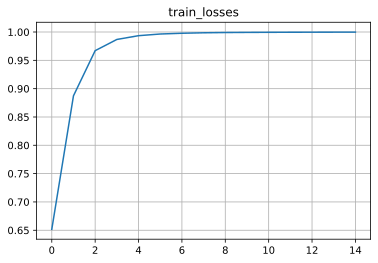

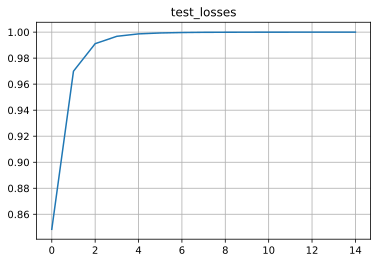

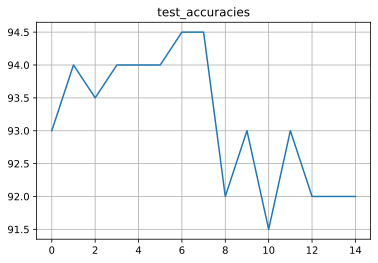

The Best accuracy is: 

tensor(94.5000)

 
 
 Test set :


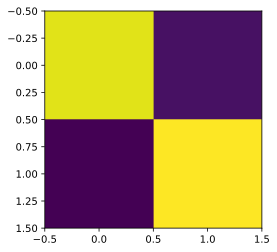

[[90 10]
 [ 6 94]]

 
 
 Train set :


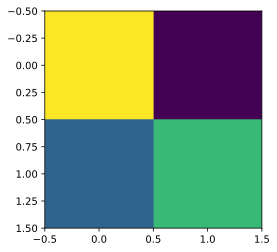

[[36254  3746]
 [14269 25731]]
ADASYN+EN neuron network without convolution


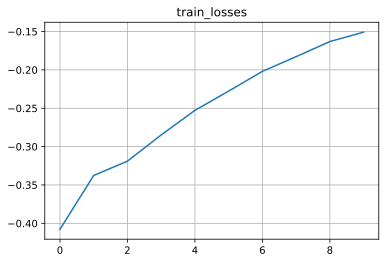

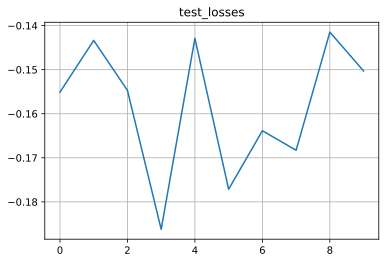

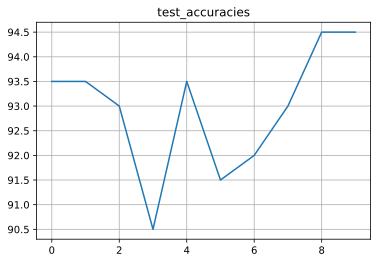

The Best accuracy is: 

tensor(94.5000)

 
 
 Test set :


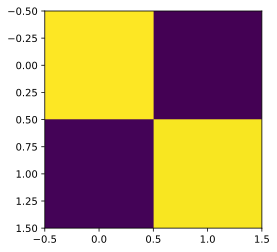

[[95  5]
 [ 6 94]]

 
 
 Train set :


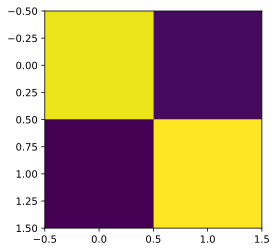

[[37921  2079]
 [  961 39039]]
ADASYN neuron network with convolution


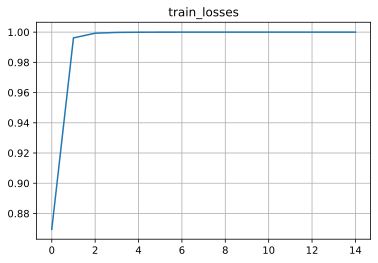

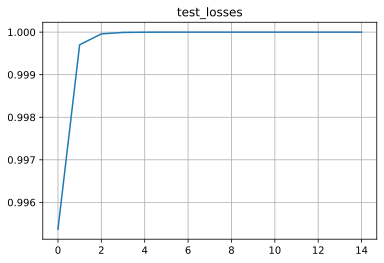

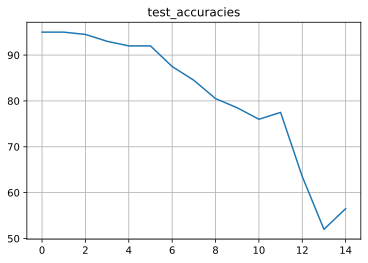

The Best accuracy is: 

tensor(95.)

 
 
 Test set :


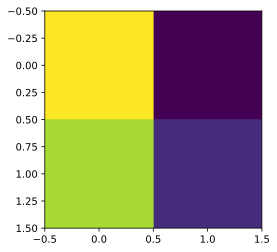

[[100   0]
 [ 87  13]]

 
 
 Train set :


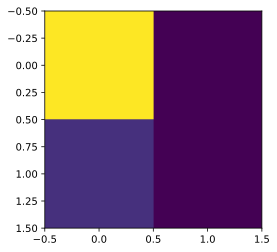

[[284209      6]
 [ 39691    309]]
ADASYN neuron network without convolution


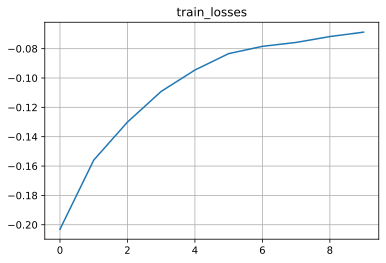

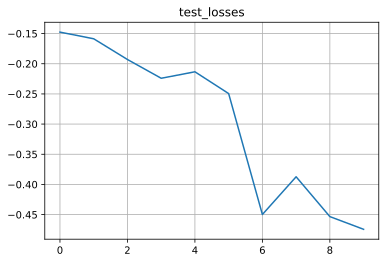

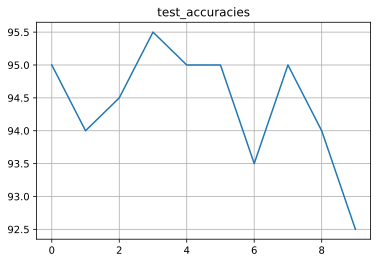

The Best accuracy is: 

tensor(95.5000)

 
 
 Test set :


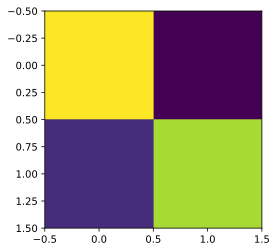

[[99  1]
 [14 86]]

 
 
 Train set :


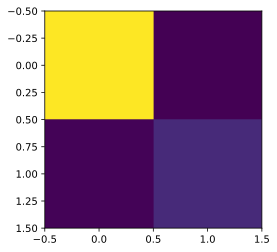

[[281966   2249]
 [  4938  35062]]


In [ ]:
model_conv, loss_fn, learning_rate, optimizer = funct_model_conv()
print('ADASYN+EN neuron network with convolution')
train(model_conv, df_train_ada_en, df_test_ada_en, conv=1,  epochs=15)

model, loss_fn, learning_rate, optimizer = funct_model()
print('ADASYN+EN neuron network without convolution')
train(model, df_train_ada_en, df_test_ada_en, conv=0,  epochs=10)

model_conv, loss_fn, learning_rate, optimizer = funct_model_conv()
print('ADASYN neuron network with convolution')
train(model_conv, df_train_ada, df_test_ada, conv=1,  epochs=15)

model, loss_fn, learning_rate, optimizer = funct_model()
print('ADASYN neuron network without convolution')
train(model, df_train_ada, df_test_ada, conv=0,  epochs=10)

## SMOTE+EN and SMOTE for a neuron network with and without convolution

SMOTE+EN neuron network with convolution


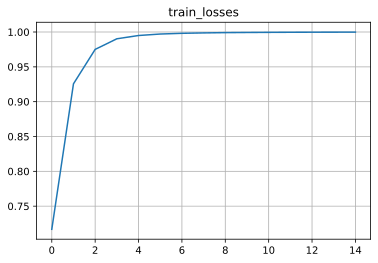

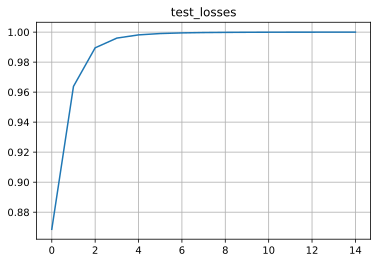

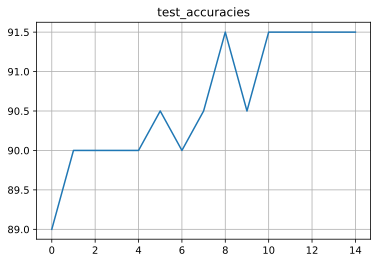

The Best accuracy is: 

tensor(91.5000)

 
 
 Test set :


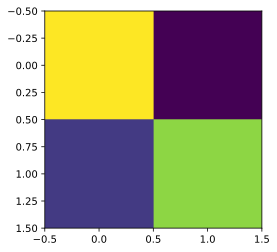

[[100   0]
 [ 17  83]]

 
 
 Train set :


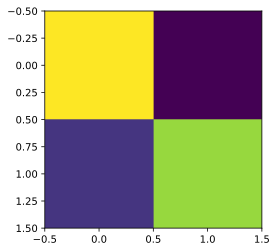

[[39913    87]
 [ 6163 33837]]
SMOTE+EN neuron network without convolution


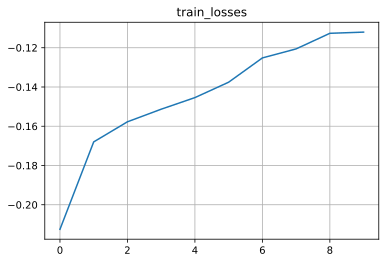

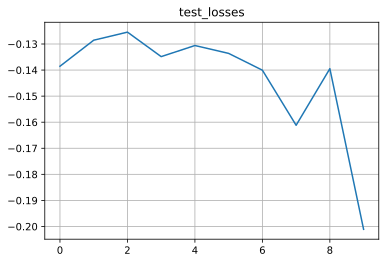

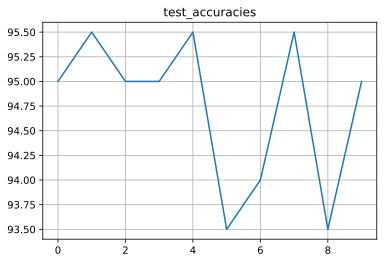

The Best accuracy is: 

tensor(95.5000)

 
 
 Test set :


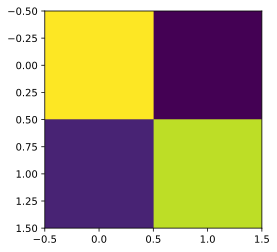

[[100   0]
 [ 10  90]]

 
 
 Train set :


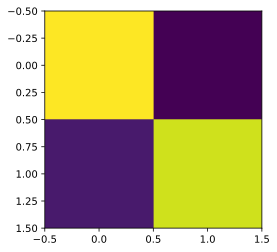

[[39590   410]
 [ 3179 36821]]
SMOTE neuron network with convolution


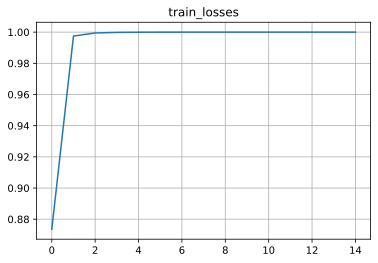

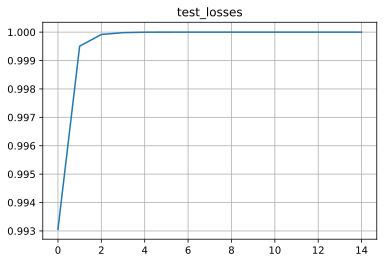

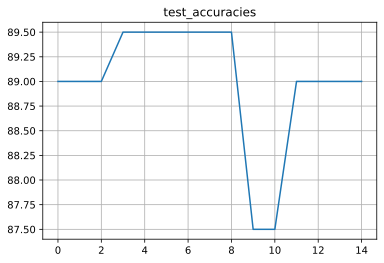

The Best accuracy is: 

tensor(89.5000)

 
 
 Test set :


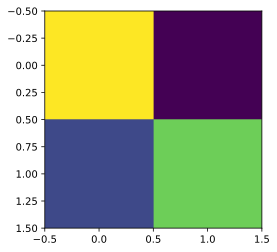

[[100   0]
 [ 22  78]]

 
 
 Train set :


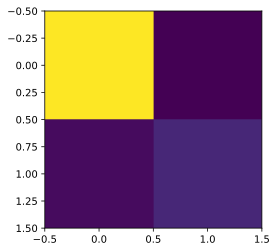

[[284133     82]
 [  7856  32144]]
SMOTE neuron network without convolution


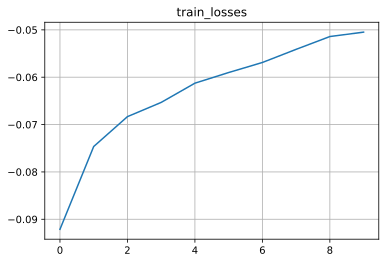

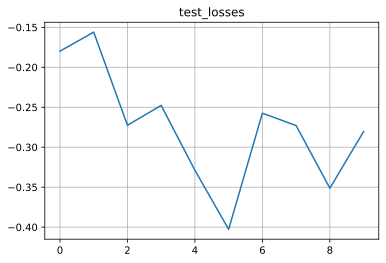

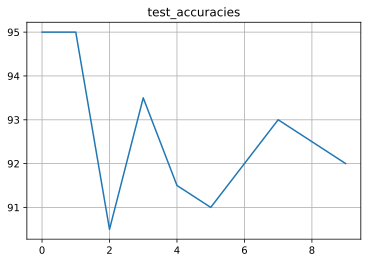

The Best accuracy is: 

tensor(95.)

 
 
 Test set :


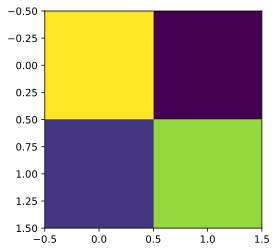

[[100   0]
 [ 16  84]]

 
 
 Train set :


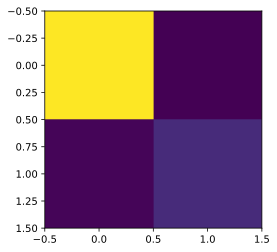

[[283882    333]
 [  4755  35245]]


In [ ]:
model_conv, loss_fn, learning_rate, optimizer = funct_model_conv()
print('SMOTE+EN neuron network with convolution')
train(model_conv, df_train_smote_en, df_test_smote_en, conv=1,  epochs=15)

model, loss_fn, learning_rate, optimizer = funct_model()
print('SMOTE+EN neuron network without convolution')
train(model, df_train_smote_en, df_test_smote_en, conv=0,  epochs=10)

model_conv, loss_fn, learning_rate, optimizer = funct_model_conv()
print('SMOTE neuron network with convolution')
train(model_conv, df_train_smote, df_test_smote, conv=1,  epochs=15)

model, loss_fn, learning_rate, optimizer = funct_model()
print('SMOTE neuron network without convolution')
train(model, df_train_smote, df_test_smote, conv=0,  epochs=10)

## Undersampling for a neuron network with and without convolution

Undersanpling neuron network with convolution


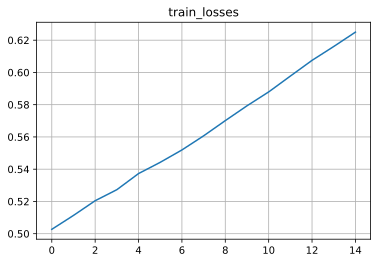

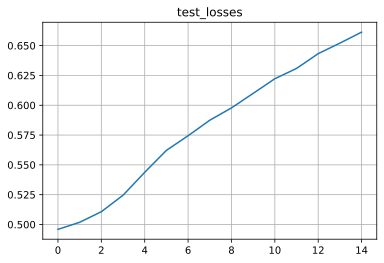

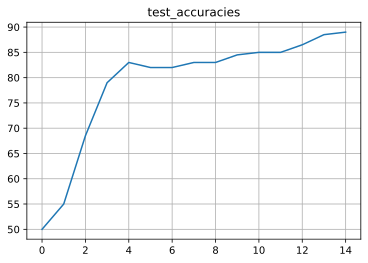

The Best accuracy is: 

tensor(89.)

 
 
 Test set :


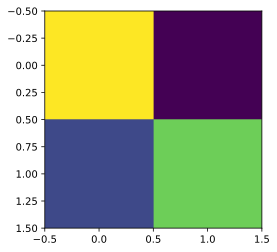

[[100   0]
 [ 22  78]]

 
 
 Train set :


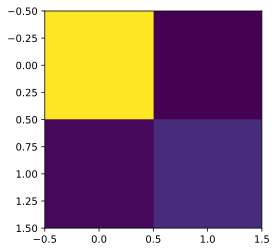

[[2329   23]
 [  77  315]]
Undersanpling neuron network without convolution


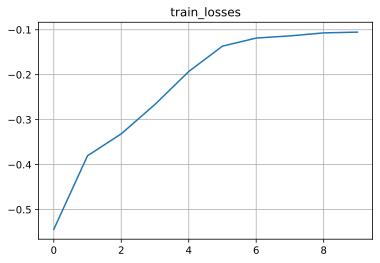

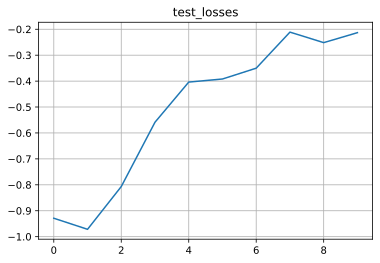

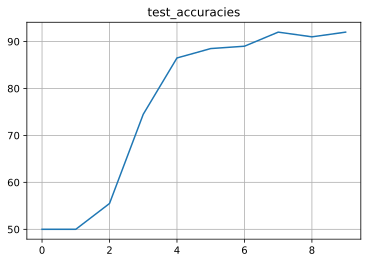

The Best accuracy is: 

tensor(92.)

 
 
 Test set :


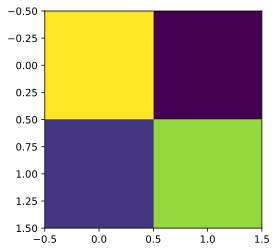

[[100   0]
 [ 16  84]]

 
 
 Train set :


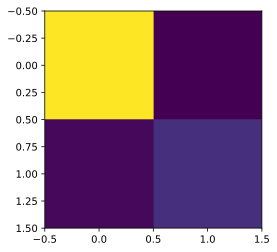

[[2342   10]
 [  56  336]]


In [ ]:
model_conv, loss_fn, learning_rate, optimizer = funct_model_conv()
print('Undersanpling neuron network with convolution')
train(model_conv, df_train_under, df_test_under, conv=1,  epochs=15)

model, loss_fn, learning_rate, optimizer = funct_model()
print('Undersanpling neuron network without convolution')
train(model, df_train_under, df_test_under, conv=0,  epochs=10)